# 机器学习作业一：KNN
- 姓名：冯思程
- 学号：2112213
- 专业：计算机科学与技术

### 实验要求
题目：基于KNN 的手写数字识别
实验条件：给定semeion手写数字数据集，给定kNN分类算法
实验要求：
1. 基本要求：编程实现kNN算法；给出在不同k值（1，3，5）情况下，kNN算法对手写数字的识别精度（要求采用留一法）
2. 中级要求：与机器学习包中的kNN分类结果进行对比
3. 提高要求：采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别

**截止日期：9月29日**
- 以学号+姓名(1)的命名形式打包实验代码+实验报告，发送到邮箱
18329300691@163.com

**环境**：python 3.10.9+vscode 1.82.2+一些必备的第三方库，例如numpy、matplotlib、random、sklearn等。

<span style="color:red">**注意**</span>：我在后文的代码都补充了详细的注释并在代码前进行了适当注释和分析，感谢学长学姐的批阅！辛苦！

### 导入需要的包


In [31]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

### 导入数据集 semeion

主要是利用内置的函数进行读取文件，并利用numpy的一些操作进行数据的整理，这里将原数据集中按照独热编码形式存储的图像类别信息转化为直接数字代表的类别信息。这里我观察数据发现，图像数据信息是0/1组成的二值图像数据，于是并不需要对数据进行规范化操作。

In [32]:
# 导入数据
def Img2Mat(fileName):
    f = open(fileName)
    ss = f.readlines()# 读取所有行存到ss中
    l = len(ss)# 记录一下行数
    f.close()# 关闭文件
    returnMat = np.zeros((l,256))# 初始化图像数据矩阵为l×256形状的零矩阵
    returnClassVector = np.zeros((l,1))# 初始化类别数据矩阵为l×1形状的零矩阵
    for i in range(l):# 按行进行遍历
        s1 = ss[i].split()# 把ss的i行按照空格分开并存到s1数组中
        for j in range(256):# 遍历s1，前256个是图像数据存到图像数据矩阵中
            returnMat[i][j] = float(s1[j])
        clCount = 0
        for j in range(256,266):# 遍历后10个数据，这是以独热编码形式存储的图像类别信息
            if s1[j] != '1':# 进行记录，转化为数字类别
                clCount += 1
            else:
                break
        returnClassVector[i] = clCount
    return returnMat,returnClassVector# 返回读取的图像数据矩阵和图像类别矩阵

调用上文定义的函数生成X和y，并进行一些shape的查看，便于后文编写代码

In [33]:
X,y = Img2Mat('semeion.data')# X中蕴含图片信息，y中是对应图片的类别，也就是图片对应的数字
# 显示一些代码来测试一下数据形状，方便后续处理
print(np.shape(X), np.shape(y)) 
#print(X[:10]) 
#print(y[:10])
#print(len(X))

(1593, 256) (1593, 1)


## 基本要求
编程实现kNN算法；给出不同k值（1，3，5）情况下，kNN算法对手写数字的识别精度（模板中采用的是普通方法分割训练集和测试集，作业中需要用留一法）

留一法的一个优点是每次迭代中都使用了最大可能数目的样本来训练。另一个优点是该方法具有确定性，下面是主要根据numpy的一些操作实现留一法和KNN算法的代码，这里KNN的主体实现主要依赖于对矩阵的相关操作（具体已经在代码中进行注释）<span style="color:red">留一法的本质就是令K折交叉检验方法的K等于数据集大小。</span>

**注意**：这里我考虑到了如果在选取标签时候，周围标签存在并列最多的情况如何处理，这里我采用的处理方法是，<span style="color:red">随机选择一个label作为其预测label</span>，这也会导致代码每次跑出来的结果有一些微小的波动，但是经过我自己的多次测试，发现波动的误差是可以被接受的。

In [34]:
from random import choice #引用随机选择包

# 手动实现留一法
def loo(data_X):
    n = len(data_X)
    for i in range(n):
        # 使用numpy的arange和布尔索引来创建训练集和测试集的索引
        train_row_index = [j for j in range(n) if j != i]
        test_row_index = [i]
        yield train_row_index, test_row_index
# 手动实现KKN算法
def MyKnnClassifier(data_X, data_y, neighbors):
    acc = 0   # 记录正确分类的个数
    # 生成数据集和测试集
    times=0 # 用来记录测试次数
    for train_row_index, test_row_index in loo(data_X):
        times+=1 # 每划分一次就是一次测试
        X_train = data_X[train_row_index, :] # 切片获取训练集和测试集
        X_test = data_X[test_row_index, :]
        y_train =data_y[train_row_index, :]
   
        y_test = data_y[test_row_index, :]
        
        testDiffMat = np.tile(X_test,(X_train.shape[0], 1)) - X_train # 利用将测试点重复构建矩阵，一次性计算出其与所有训练点的差异矩阵

        sqTestDiffMat = testDiffMat ** 2    # 将差异矩阵逐元素进行平方

        sqTestDiffDis = sqTestDiffMat.sum(axis=1) #对平方后的差异矩阵进行逐行求和

        testDiffDis = sqTestDiffDis ** 0.5  # 开方生成欧氏距离

        sortIndex = np.argsort(testDiffDis)   # 按欧式距离升序排序并将排序后的索引输出
        
        labelCount = []
        for j in range(neighbors):  # 考察k近邻属于哪些类
            labelCount.append(y_train[sortIndex[j]][0])
        classifyRes = Counter(labelCount)   
        # 获取最大的计数
        max_count = classifyRes.most_common(1)[0][1]
        # 找到所有计数与最大计数相同的元素
        most_common_labels = [label for label, count in classifyRes.items() if count == max_count]
        # 随机选择一个label作为测试点的label（这里是为了处理有多个计数都是最大的元素）
        predicted_label = choice(most_common_labels)

        if predicted_label == y_test[0][0]:  # 分类正确则将acc+1
            acc += 1
        #testRes = []  # 存放测试结果
        #testRes.append(classifyRes)

    accRate = acc / times
    print('k={0}时，留一法测试次数为{1}  正确个数为：{2}  准确率为：{3}'.format(neighbors,times,acc,accRate))
    return accRate

手搓KNN+留一法实验结果：

In [35]:
# 分别测试k等于1、3、5时候手动搭建的KNN算法的准确率
MyKnnClassifier(X, y, 1)
MyKnnClassifier(X, y, 3)
MyKnnClassifier(X, y, 5)

k=1时，留一法测试次数为1593  正确个数为：1459  准确率为：0.9158819836785939
k=3时，留一法测试次数为1593  正确个数为：1454  准确率为：0.9127432517263026
k=5时，留一法测试次数为1593  正确个数为：1454  准确率为：0.9127432517263026


0.9127432517263026

## 中级要求
与机器学习包中的kNN分类结果进行对比

### Scikit-Learn包：
这里也采用留一法+KNN算法，对全部数据点进行测评

In [36]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

def sci_knn(X, y, k):
    y=y.ravel()
    # 初始化KNN分类器
    knn = KNeighborsClassifier(n_neighbors=k)

    # 初始化留一法
    loo = LeaveOneOut()

    correct_predictions = 0

    # 对于每一个留一法的划分，进行训练和测试
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 使用训练数据训练KNN分类器
        knn.fit(X_train, y_train)

        # 对测试数据进行预测
        y_pred = knn.predict(X_test)

        # 检查预测是否正确
        if y_pred == y_test:
            correct_predictions += 1

    # 计算准确率
    accuracy = correct_predictions / len(X)
    print('k={0}时，调用Scikit-Learn包的准确率为：{1}'.format(k,accuracy))
    return accuracy

Scikit-Learn包实验结果：（运行时间长一点）

In [37]:
sci_knn(X,y,1)
sci_knn(X,y,3)
sci_knn(X,y,5)

k=1时，调用Scikit-Learn包的准确率为：0.9171374764595104
k=3时，调用Scikit-Learn包的准确率为：0.903954802259887
k=5时，调用Scikit-Learn包的准确率为：0.9052102950408035


0.9052102950408035

### 对比可视化：
这里由于k如果只取1、3、5画出的图线过于单一，于是我在这里分别选取1、3、5、7、9、11、13、15、17进行测试并画出对比折线图，根据多次测试结果发现我个人手搓实现的模型的效果要略优于scikit_learn包的模型。

k=1时，留一法测试次数为1593  正确个数为：1459  准确率为：0.9158819836785939
k=3时，留一法测试次数为1593  正确个数为：1453  准确率为：0.9121155053358443
k=5时，留一法测试次数为1593  正确个数为：1457  准确率为：0.9146264908976773
k=7时，留一法测试次数为1593  正确个数为：1461  准确率为：0.9171374764595104
k=9时，留一法测试次数为1593  正确个数为：1462  准确率为：0.9177652228499686
k=11时，留一法测试次数为1593  正确个数为：1447  准确率为：0.9083490269930948
k=13时，留一法测试次数为1593  正确个数为：1449  准确率为：0.9096045197740112
k=15时，留一法测试次数为1593  正确个数为：1445  准确率为：0.9070935342121783
k=17时，留一法测试次数为1593  正确个数为：1430  准确率为：0.8976773383553045
k=1时，调用Scikit-Learn包的准确率为：0.9171374764595104
k=3时，调用Scikit-Learn包的准确率为：0.903954802259887
k=5时，调用Scikit-Learn包的准确率为：0.9052102950408035
k=7时，调用Scikit-Learn包的准确率为：0.9096045197740112
k=9时，调用Scikit-Learn包的准确率为：0.911487758945386
k=11时，调用Scikit-Learn包的准确率为：0.9096045197740112
k=13时，调用Scikit-Learn包的准确率为：0.9033270558694287
k=15时，调用Scikit-Learn包的准确率为：0.8983050847457628
k=17时，调用Scikit-Learn包的准确率为：0.8945386064030132


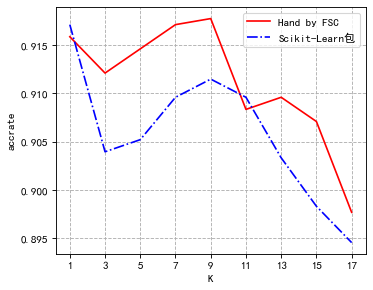

In [39]:
plt.rcParams['font.sans-serif']=['SimHei']   #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# 准备数据x y，这里我直接去调用了上文的方法，而不是直接记录数据，保证每次都可以看到效果的实时对比
x=range(1,18,2)
y_handbyfsc=[MyKnnClassifier(X, y, 1),MyKnnClassifier(X, y, 3),MyKnnClassifier(X, y, 5),MyKnnClassifier(X, y, 7),MyKnnClassifier(X, y, 9),MyKnnClassifier(X, y, 11),MyKnnClassifier(X, y, 13),MyKnnClassifier(X, y, 15),MyKnnClassifier(X, y, 17)]
y_slearn=[sci_knn(X,y,1),sci_knn(X,y,3),sci_knn(X,y,5),sci_knn(X,y,7),sci_knn(X,y,9),sci_knn(X,y,11),sci_knn(X,y,13),sci_knn(X,y,15),sci_knn(X,y,17)]

# 创建
plt.figure(figsize=(5,4),dpi=80)

# 绘制图像
plt.plot(x,y_handbyfsc,color='r',linestyle='-',label="Hand by FSC")
plt.plot(x,y_slearn,color='b',linestyle='-.',label="Scikit-Learn包")
plt.legend()
plt.grid(linestyle="--")
x = [1,3,5,7,9,11,13,15,17]
plt.xticks(x)
plt.xlabel("K")
plt.ylabel("accrate")
# 显示
plt.show()

## 提高要求
采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别

### 数据增强

首先，我在这里要进行数据增强操作，由于原数据集只给出了1593个数据点，这对神经网络是有一些不够的，所以通过数据增强增加数据量，同时还提升了模型的鲁棒性以及泛化能力。这里我采用的数据增强方法有：旋转（-15°到15°）、缩放（0.9至1.1）、适度随机噪声（2%至10%）。<span style="color:red">注意：没有采用翻转是因为数字翻转后会变成另外一个数字(例如6和9)、没有采用对比度或亮度调整是因为图像是二值图像。</span>

具体地，我首先按照**7：3**的比例将原数据集划分为训练集和测试集，然后利用上述数据增强方法对训练集进行数据增强，最后测试集规模为477，增强训练集规模为17856。

注意：只有训练数据需要数据增强，测试集这里不进行数据增强

In [40]:
import random
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.ndimage import rotate
import numpy as np


# 重新导入数据，类别用独热编码方式输入
def Img2Matcnn(fileName):
    f = open(fileName)
    ss = f.readlines()
    l = len(ss)
    f.close()
    returnMat = np.zeros((l,256))
    returnClassVector = np.zeros((l,10))
    for i in range(l):
        s1 = ss[i].split()
        for j in range(256):
            returnMat[i][j] = float(s1[j])
        for j in range(256,266):
            returnClassVector[i][j-256] = int(s1[j])
    return returnMat,returnClassVector

X_cnn,y_cnn = Img2Matcnn('semeion.data')

def divide(data_X,data_y): #按照0.3比例划分测试集和训练集
    indexs = random.sample(range(0, len(data_X)), int(0.3*len(data_X)))

    X_test = data_X[indexs, :] # 切片获取选中的测试集
    y_test = data_y[indexs, :]

    # 获取训练集在原数据集的索引
    tindexs = np.delete(np.arange(len(data_X)), indexs)

    X_train = data_X[tindexs, :]
    y_train = data_y[tindexs, :]

    return X_test,X_train,y_test,y_train

def scale_image(image, scale_factor):
    scaled_image = zoom(image, (scale_factor, scale_factor, 1), order=0)
    # 计算填充和裁剪的大小
    pad_size = (16 - scaled_image.shape[0]) // 2
    remainder = (16 - scaled_image.shape[0]) % 2

    if scaled_image.shape[0] < 16:
        scaled_image = np.pad(
            scaled_image,
            (
                (pad_size, pad_size + remainder),
                (pad_size, pad_size + remainder),
                (0, 0),
            ),
            mode="constant",# 使用常数值0进行图像填充
        )
    elif scaled_image.shape[0] > 16:
        crop_size = (scaled_image.shape[0] - 16) // 2
        scaled_image = scaled_image[
            crop_size : -crop_size - remainder, crop_size : -crop_size - remainder, :
        ]

    return scaled_image

def addnoise(image, noise_ratio):# 实现随机噪声添加
    noise_mask = np.random.choice([True, False], size=image.shape, p=[noise_ratio, 1-noise_ratio])#根据噪声比例随机选择要进行像素点值进行反转的位置
    
    noisy_image = np.where(noise_mask, 1 - image, image)# 用（1-像素值）即可实现二值图像的像素值翻转
    
    return noisy_image

def rotate_and_resize(image, angle):
    padded_image = np.pad(image, ((8, 8), (8, 8), (0, 0)), mode='constant', constant_values=0)
    rotated_image = rotate(padded_image, angle, reshape=False, mode='nearest', order=0)# 这里旋转后的像素值确定是最邻近插值
    
    # 将图像调整到32×32的形状
    if rotated_image.shape[0] != 32 or rotated_image.shape[1] != 32:
        diff0 = 32 - rotated_image.shape[0]
        diff1 = 32 - rotated_image.shape[1]
        rotated_image = np.pad(rotated_image, ((diff0//2, diff0 - diff0//2), (diff1//2, diff1 - diff1//2), (0, 0)), mode='constant', constant_values=0)
    # 直接将32×32形状的图像缩小为0.5倍
    resized_image = zoom(rotated_image, (0.5, 0.5, 1), order=0)
    return resized_image


def dataenhance(datatrainX, datatrainy):# 数据增强函数
    datatrainX = datatrainX.reshape((len(datatrainX), 16, 16, 1))
    
    augmented_X = []
    augmented_y = []
    
    for i in range(len(datatrainX)):
        image = datatrainX[i]
        label = datatrainy[i]
        
        # 添加原始图像
        augmented_X.append(image)
        augmented_y.append(label)
        
        # 添加缩放图像
        for j in (0.9,0.95,1.05,1.1):
            scaled_image = scale_image(image, j)
            augmented_X.append(scaled_image)
            augmented_y.append(label)
        
        # 添加噪声图像
        for k in (0.02,0.04,0.06,0.08,0.1):
       
            noisy_image = addnoise(image,k)
            augmented_X.append(noisy_image)
            augmented_y.append(label)
            
        # 添加旋转图像
        for m in (-15,-10,-5,5 ,10, 15):
            rotated_resized_image = rotate_and_resize(image,m )
            augmented_X.append(rotated_resized_image)
            augmented_y.append(label)
        
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)


    return augmented_X, augmented_y

X_test,X_train,y_test,y_train=divide(X_cnn,y_cnn) #划分完的训练集和测试集


X_train,y_train=dataenhance(X_train,y_train) # 数据增强完的训练集

X_train=X_train.reshape((len(X_train),256)) # 训练集reshape，以适应后续cnn训练

print(len(X_test),len(y_test),len(X_train),len(y_train)) # 查看一下增强后的训练集和测试集的规模


print(np.shape(X_test),np.shape(y_test),np.shape(X_train), np.shape(y_train)) # 查看一下增强后的训练集和测试集的shape

477 477 17856 17856
(477, 256) (477, 10) (17856, 256) (17856, 10)


### Network搭建
这里选用CNN，这里我选择的方法是双层神经网络，分别为输入层、中间层、输出层。其中输入有256个神经元、输出是10个神经元。其中初始权重标准差、中间层规模、学习率用网格搜索法进行最佳参数搜索。其中参数更新是利用了反向传播法，大大提升计算速度。为了优化模型，我使用了mini-batch梯度下降法进行训练，并在每轮训练后计算并打印出训练和测试的准确率。

注意：这里用网格搜索法进行参数空间搜索，所以运行运行实践较长。


In [ ]:
import numpy as np
# 一些要用到的函数：
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - x) * x

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_error(y, t):# 交叉熵损失函数
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

class FSCNet:
    def __init__(self, input_size=256, hidden_size=100, output_size=10, weight_init_std=0.01):
        # 初始化权重和偏置
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):#用softmax函数算出每个类别的概率
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y

    def loss(self, x, t):# 利用交叉熵函数计算损失
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):# 准确率
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):# 梯度传递
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        batch_num = x.shape[0]

        # 前向
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # 后向
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(z1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads
    # 训练函数
    def fit(self, X_train, y_train, X_test, y_test, epochs=150, batch_size=128, learning_rate=0.15):#mini-batch训练
        for epoch in range(epochs):
            permutation = np.random.permutation(X_train.shape[0])
            X_train_shuffled = X_train[permutation]
            y_train_shuffled = y_train[permutation]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                grads = self.gradient(X_batch, y_batch)
                for key in self.params.keys():
                    self.params[key] -= learning_rate * grads[key]

            train_acc = self.accuracy(X_train, y_train)
            test_acc = self.accuracy(X_test, y_test)
            # 每轮结束输出一次准确率
            print(f"Epoch {epoch+1}/{epochs}, 训练集准确率: {train_acc:.4f}, 测试集准确率: {test_acc:.4f}")

# 定义参数搜索空间
hidden_sizes = [50, 100, 150, 200]
learning_rates = [0.05, 0.1, 0.15, 0.2]
weight_init_stds = [0.005,0.01, 0.05, 0.1]

# 初始化最佳参数和准确率
best_accuracy = 0.0
best_params = {# 定义字典存储最佳参数
    'hidden_size': None,
    'learning_rate': None,
    'weight_init_std': None
}

# 网格搜索搜索最佳参数
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for weight_init_std in weight_init_stds:
            print(f"Training with hidden_size={hidden_size}, learning_rate={learning_rate}, weight_init_std={weight_init_std}")
            net = FSCNet(hidden_size=hidden_size, weight_init_std=weight_init_std)
            net.fit(X_train, y_train, X_test, y_test, learning_rate=learning_rate)
            accuracy = net.accuracy(X_test, y_test)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params['hidden_size'] = hidden_size
                best_params['learning_rate'] = learning_rate
                best_params['weight_init_std'] = weight_init_std
# 输出最优参数以及对应准确率
print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.4f}")

#net = FSCNet()

#net.fit(X_train, y_train, X_test, y_test)


Training with hidden_size=50, learning_rate=0.05, weight_init_std=0.005
Epoch 1/150, 训练集准确率: 0.1093, 测试集准确率: 0.0818
Epoch 2/150, 训练集准确率: 0.1093, 测试集准确率: 0.0818
Epoch 3/150, 训练集准确率: 0.1093, 测试集准确率: 0.0818
Epoch 4/150, 训练集准确率: 0.1075, 测试集准确率: 0.0860
Epoch 5/150, 训练集准确率: 0.1944, 测试集准确率: 0.2138
Epoch 6/150, 训练集准确率: 0.1822, 测试集准确率: 0.2034
Epoch 7/150, 训练集准确率: 0.2164, 测试集准确率: 0.2474
Epoch 8/150, 训练集准确率: 0.2801, 测试集准确率: 0.3417
Epoch 9/150, 训练集准确率: 0.3894, 测试集准确率: 0.4990
Epoch 10/150, 训练集准确率: 0.4144, 测试集准确率: 0.5241
Epoch 11/150, 训练集准确率: 0.4927, 测试集准确率: 0.6226
Epoch 12/150, 训练集准确率: 0.5471, 测试集准确率: 0.6373
Epoch 13/150, 训练集准确率: 0.5829, 测试集准确率: 0.6918
Epoch 14/150, 训练集准确率: 0.6279, 测试集准确率: 0.7086
Epoch 15/150, 训练集准确率: 0.6576, 测试集准确率: 0.7610
Epoch 16/150, 训练集准确率: 0.6762, 测试集准确率: 0.7736
Epoch 17/150, 训练集准确率: 0.6853, 测试集准确率: 0.7799
Epoch 18/150, 训练集准确率: 0.7054, 测试集准确率: 0.7862
Epoch 19/150, 训练集准确率: 0.7124, 测试集准确率: 0.7987
Epoch 20/150, 训练集准确率: 0.7232, 测试集准确率: 0.8176
Epoch 21/150, 训练集准确率: 0.7350, 测试集准确率:

对比手搓KNN和sklearn的KNN，我们可以发现CNN方法是优于KNN算法的，准确率几乎都可以到达0.93+，最高接近0.94，而且这只是一个较为简单的卷积神经网络，可以预见的是，如果继续增加一些复杂性可以让准确性更上一层楼。